This file is part of GaPSE
Copyright (C) 2022 Matteo Foglieni

GaPSE is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

GaPSE is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU
General Public License for more details.

You should have received a copy of the GNU General Public License
along with GaPSE. If not, see <http://www.gnu.org/licenses/>.
```


```

# GaPSE TUTORIAL

This is a small tour of the Galaxy Power Spectrum Estimator software. It shows
how the program can be easily used inside a Jupyter Notebook.

However, if you prefer, you can also write the commands you are interested to execute inside the file "GaPSE-exe.jl", and then run in the command line

```
$ julia GaPSE-exe.jl
```

Furthermore, almost all the function implemented inside GaPSE have a detailed documentation; feel free to check it whenever you want with the usual Julia command `?NAME` (where `NAME` is the name of the function/object you are interested in).

### Table of Content
- Path to GaPSE
- Creation of a Cosmology 
- TPCF of a single effect



## Path to GaPSE

In [1]:
# In case you prefer to use GaPSE in a Jupyter Notebook in a "distant" directory,
# you only have to set this path to the direcory GaPSE is sotred in.
PATH_TO_GAPSE = "../"; 

In [2]:
include(PATH_TO_GAPSE * "src/GaPSE.jl");
# NOTE : do not run this cell multiple times! In you have a problem, restart
# the kernel an re-run all the cells.

In [3]:
using DelimitedFiles, Plots, Printf, LaTeXStrings 
# These are useful libraries

```




```

## Creation of a Cosmology 

We must create a struct `Cosmology`, that will contains all the 
relevant information for future computations.
In order to do so, we must give 3 input files:
- the file containing the matter power spectrum we are focused on;
- the file containing the background data for the Universe considered;
- the file containing a map on μ and x of the window function F (use the 
  default one initially, provided inside GaPSE directory `data`);
  
The first two files should be produced by the [CLASS](https://github.com/lesgourg/class_public) software. As an example, we take the two
stored inside `data`.

In [4]:
FILE_PS = PATH_TO_GAPSE * "data/WideA_ZA_pk.dat";
FILE_BACKGROUND = PATH_TO_GAPSE * "data/WideA_ZA_background.dat";
FILE_F_MAP = PATH_TO_GAPSE * "data/F_REFERENCE.txt";

Now we have to set the dimensions of the survey we are considering. 
GaPSE assumes for the survey volume an azimutally simmetric one, contained inside two concentric spheres (with radius specified by the input minimum and maximum redshifts `z_min` and `z_max`) and with angular extensions `2 θ_max` (so `θ_max` is the angle between the central axis and the edge).

<img src="images/survey.png" style="width: 400px;">

If you are not interested in a specific survey, but only in the "true" TPCF, do not worry: let the default values for these fields, in the functions you will only have 
to set `use_window = false`.

In [5]:
z_min, z_max, θ_max = 0.05, 0.20, π / 2.0;

At this point, we have to create a `CosmoParams` struct, that will contains all the
options to be passed to `Cosmology`.
Beyond the already mentioned `z_min`, `z_max` and `θ_max` (which are mandatory), you may choose to specify:
- `Ω_b::Float64`, `Ω_cdm::Float64` and `Ω_M0::Float64` : barionic, cold-dark-matter and total matter density parameters

- `h_0::Float64` : today's Hubble adimensional parameter (`H_0 = h_0 * 100 km/(s * Mpc)`).

- many others; if you are interested, check the documentation of `CosmoParams`.

Here we provided the full list of them, with all their default values.

In [6]:
params = GaPSE.CosmoParams(z_min, z_max, θ_max;
    Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70, s_lim=1e-2,
    IPS_opts = Dict(
        :fit_left_min => 1e-6, :fit_left_max => 3e-6,
        :fit_right_min => 1e1, :fit_right_max => 2e1),
    IPSTools_opts = Dict(
        :N => 1024, :fit_min => 0.05, :fit_max => 0.5, 
        :con => true, :k_min => 1e-8, :k_max => 10.0),
);

Finally, we can create the `Cosmology` (let's call it `cosmo`) with all the inputs specified before!
We also print on the screen all the options stored by that `Cosmology` itself, in order to be sure that everything is okay.

In [7]:
cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP);

GaPSE.parameters_used(stdout, cosmo);

###############
#    GaPSE    #
############### 
#
# The Cosmology considered had the following paremeters:
# 
# - Matter Power Spectrum input file: "../data/WideA_ZA_pk.dat"
# - F window function input file: "../data/F_REFERENCE.txt"
# - Background data input file: "../data/WideA_ZA_background.dat"
#
# - Basic CosmoParams considered: 
#	 z_min = 0.05 	 z_max = 0.2
#	 θ_max = 1.5707963267948966 [rad] 	 h_0 = 0.7
#	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
#
# - CosmoParams about the Input Power Spectrum: 
#	 fit_left_min = 1.0e-6 	 fit_right_min = 10.0 	 
#	 fit_left_max = 3.0e-6 	 fit_right_max = 20.0 	 
#
# - CosmoParams about the Input Power Spectrum Tools: 
#	 k_max = 10.0 	 fit_max = 0.5 	 N = 1024 	 
#	 con = true 	 k_min = 1.0e-8 	 fit_min = 0.05 	 
#
# - Computed quantities: 
# 	 effective redshift z_eff = 0.15045636096023224 
# 	 comoving s_min = 148.1920001465757 Mpc/h_0
# 	 comoving s_max = 571.7022420258767 Mpc/h_0
# 	 comoving s_eff = 435.3747095690664 Mpc/h_0
# 	 V

Now we are ready to calculate the TPCF and/or PS associated with each of the GR effects for this Universe!

```




```

## TPCF of a single effect

The GR effects are 4: Doppler, Lensing, Local GP and Integrated GP (where GP stands for Gravitational Potential).

Consequently, the Two-Point Correlation Functions associated are 16 (4 are auto-correlations, and 12 the cross-ones; note that they are not simmetric, so Lensing-Doppler is different fro Doppler-Lensing).

Their names are, with obvious associations, the ones contained inside the
`GaPSE.IMPLEMENTED_GR_EFFECTS` vector:

In [8]:
GaPSE.IMPLEMENTED_GR_EFFECTS 

16-element Vector{String}:
 "auto_doppler"
 "auto_lensing"
 "auto_localgp"
 "auto_integratedgp"
 "lensing_doppler"
 "doppler_lensing"
 "doppler_localgp"
 "localgp_doppler"
 "doppler_integratedgp"
 "integratedgp_doppler"
 "lensing_localgp"
 "localgp_lensing"
 "lensing_integratedgp"
 "integratedgp_lensing"
 "localgp_integratedgp"
 "integratedgp_localgp"

As a first example, we will focus on the Doppler auto-correlation function, identified by the name `auto_doppler`.

How we may calculate the value of such TPCF, for the considered Cosmology `cosmo`?
GaPSE provides three functions:

- `ξ_multipole`
- `map_ξ_multipole`
- `print_map_ξ_multipole`

The frame of reference you have to keep in mind is the following:

<img src="images/s1s2.png" style="width: 300px;">

`ξ_multipole(s1, s, effect::String, cosmo::Cosmology; L::Integer = 0, kwargs...)`  returns the value of the chosen GR `effect` multipole (of order `L`) calculated in `s1` and a distance `s` from it.

In [ ]:
GaPSE.print_mapξ_multipole(cosmo, "my_first_doppler.txt", "auto_doppler", 
    10 .^ range(0, 3, length = 1000); L = 0, use_windows = false)

- `map_ξ_multipole(cosmo::Cosmology, effect::String, v_ss::Union{Vector{Float64},Nothing} = nothing; s_1::Union{Float64,Nothing} = nothing L::Integer = 0, kwargs...)` : return the vector of values of the chosen GR `effect` multipole (of order `L`) calculated in `s1` and a distance `s` from it
- print_map_ξ_multipole

For instance, let's print on a file named `my_first_doppler.txt` the `auto_doppler`
TPCF monopole (`L=0`), calculated in the vector of values `ss = 10 .^ range(0, 3, length = 1000)`.
The GaPSE command we are interested in is `GaPSE.print_map_ξ_multipole`.

For this first run, let's forget the survey volume; we only have to set `use_windows = false`.
Of course, we have to pass as input the `Cosmology` previously created, called `cosmo`!

In [9]:
GaPSE.print_map_ξ_multipole(cosmo, "my_first_doppler.txt", "auto_doppler", 
    10 .^ range(0, 3, length = 1000); L = 0, use_windows = false)

auto_doppler, L=0: 100%|████████████████████████████████| Time: 0:00:01



time needed for map_integral_on_mu for auto_doppler [in s] = 1.66749 


Here we plot the result:

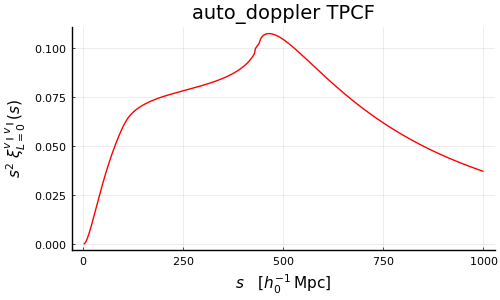

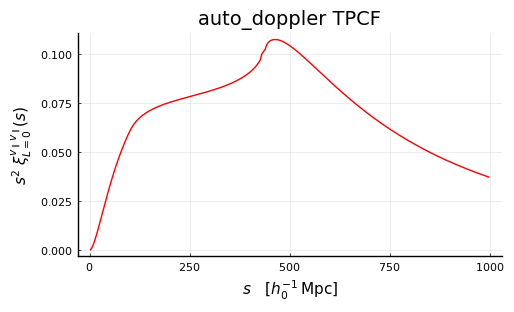

In [16]:
table = readdlm("my_first_doppler.txt", comments=true)
xs = convert(Vector{Float64}, table[:,1])
ys = convert(Vector{Float64}, table[:,2])

pyplot()
P = plot(xs, ys .* xs .^2,
    #xaxis=:log, #yaxis=:log, 
    lc=:red, ls=:solid,size=(500, 300),
    title="auto_doppler TPCF",
    ylabel=L"s^2 \; \xi^{v_{\parallel} \, v_{\parallel}}_{L=0}(s)",
    xlabel=L"s \quad [h_0^{-1}\,\mathrm{Mpc}]",
    legend=false,
)
#savefig(P, "my_first_doppler.pdf");
display(P)